In [1]:
from __future__ import absolute_import, division, print_function
import sys
import collections 

import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar100, cifar10
from tqdm import tqdm
from IPython.display import clear_output

from scan_tf.models.resnet import resnet_18, resnet_34, resnet_50, resnet_101, resnet_152, add_classification_layer, remove_classification_layer
import scan_tf.utils.utils as utils
import scan_tf.utils.augmentations as augmentations


# Grow memory to avoid mem overflow
memory_growth=True
if memory_growth:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
      except RuntimeError as e:
        print(e)

In [2]:
# Model configuration
img_width, img_height, img_num_channels = 32, 32, 3
no_epochs = 100
optimizer = tf.keras.optimizers.Adam()
validation_split = 0.2
verbosity = 1

# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train[:1000]
y_train = y_train[:1000]



X_train.shape
input_train = X_train
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Find number of classes dynamically
num_classes = y_train.shape[1]

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Normalize data
X_train = (X_train/255).astype(np.float32)
X_test = (X_test/255).astype(np.float32)


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape : {X_train.shape}")
print(f"y_test shape : {y_test.shape}")

X_train shape: (1000, 32, 32, 3)
y_train shape: (1000, 10)
X_test shape : (1000, 32, 32, 3)
y_test shape : (10000, 10)


In [3]:
model = resnet_18(n_output=128)
model.build(input_shape=(None, img_width, img_height, img_num_channels))
model.summary()

Model: "res_net_type_i"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9472      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
sequential (Sequential)      multiple                  148736    
_________________________________________________________________
sequential_1 (Sequential)    multiple                  527488    
_________________________________________________________________
sequential_3 (Sequential)    multiple                  2103552   
_________________________________________________________________
sequential_5 (Sequential)    multiple               

In [4]:
model_2 = add_classification_layer(model, num_classes=2)
model_2.build(input_shape=(None, img_width, img_height, img_num_channels))
model_2.summary()
model_bis = remove_classification_layer(model_2)
model_bis.build(input_shape=(None, img_width, img_height, img_num_channels))
model_bis.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9472      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
sequential (Sequential)      multiple                  148736    
_________________________________________________________________
sequential_1 (Sequential)    multiple                  527488    
_________________________________________________________________
sequential_3 (Sequential)    multiple                  2103552   
_________________________________________________________________
sequential_5 (Sequential)    multiple                 

<h3>Training for minimizing the Rotation Loss</h3>

In [12]:
def pretext_training(model, X_train, y_train):
    lr = 1e-4
    e = 0
    m = X_train.shape[0]
    batch_size = 128

    while True:
        e+=1
        batch_count = 0
        for idx in range(0, m, batch_size): # batch
            images = tf.convert_to_tensor(X_train[idx:idx+batch_size, ...])
            labels = tf.convert_to_tensor(y_train[idx:idx+batch_size, ...])
            if True:
                degrees_to_rotate = np.random.choice([90, 180, 270]) # randomly choosing the rotation angle
                images_rotated = tf.convert_to_tensor(scipy.ndimage.rotate(images, degrees_to_rotate, axes=(2, 1))) 
                
                with tf.GradientTape() as tape:
                    embs_a, embs_b = model(images), model(images_rotated)
                    #norm = tf.map_fn(tf.nn.l2_loss, embs_a-embs_b)
                    #loss = tf.reduce_mean(norm)
                    loss = tf.reduce_sum(tf.norm(embs_a-embs_b, ord='euclidean', axis=(1), keepdims=None, name=None))
                    grads = tape.gradient(loss, model.trainable_weights)
                    optimizer = tf.keras.optimizers.Adam(lr=lr)
                    optimizer.apply_gradients(zip(grads, model.trainable_weights))
                    
            else:
                images_augmented = tf.convert_to_tensor(augmentations.strong_augmentation_ims(X_train[idx:idx+batch_size, ...], is_array=True))
                with tf.GradientTape() as tape:
                    embs_images = model(images)
                    embs_images_augmented = model(images_augmented)
                    norm = tf.map_fn(tf.nn.l2_loss, embs_images-embs_images_augmented)
                    loss = tf.reduce_mean(norm)
                    grads = tape.gradient(loss, model.trainable_weights)
                    optimizer = tf.keras.optimizers.Adam(lr=lr)
                    optimizer.apply_gradients(zip(grads, model.trainable_weights))
                
            if np.isnan(loss):
                print("Nan loss found:")
                print(embs_images.dtype, embs_images_augmented.dtype, norm.dtype, loss.dtype, grads.dtype)
                print(embs_images[1])
                print(embs_images_augmented[1])
                print(f"epoch {e}, batch {batch_count} loss: {loss}")
                return model

            batch_count+=1
        if e%1 == 0:
            #clear_output()
            print(f"epoch {e}, loss: {loss}")
        if e==20:
            break
    return model

pretext_model = pretext_training(model, X_train, y_train)

epoch 1, loss: 4.062341213226318
epoch 2, loss: 1.7168891429901123
epoch 3, loss: 0.8262642621994019
epoch 4, loss: 0.48363369703292847
epoch 5, loss: 0.26595503091812134
epoch 6, loss: 0.16309602558612823
epoch 7, loss: 0.09385877102613449
epoch 8, loss: 0.05685226619243622
epoch 9, loss: 0.03577381372451782
epoch 10, loss: 0.022338680922985077
epoch 11, loss: 0.0153864286839962
epoch 12, loss: 0.011010964401066303
epoch 13, loss: 0.007793831638991833
epoch 14, loss: 0.007047489285469055
epoch 15, loss: 0.0043836794793605804
epoch 16, loss: 0.003693177830427885
epoch 17, loss: 0.00289282388985157
epoch 18, loss: 0.002204954857006669
epoch 19, loss: 0.0019571527373045683
epoch 20, loss: 0.0015922024613246322


In [11]:
pretext_model.save_weights("pretext_task_rotnet.h5")

<h3>Finding Nearest Neighbors (for debugging)</h3>

In [41]:
def find_neighbor_consistancy(images, labels, n_neighbors=5, plot=False):
    nn = utils.CLusteringNN(model, n_neighbors=5)
    nn.fit(images)
    nn_indexes = nn.get_neighbors_indexes(images)
    print(nn_indexes)
    return 0
    consistancies = list()
    true_classes = np.argmax(labels, axis=1)
    for cluster_indexes in nn_indexes:
        cluster_classes = true_classes[cluster_indexes]
        # Not sure which formula is better
        consistancy = (cluster_classes[1:]==cluster_classes[0]).sum()/(len(cluster_indexes)-1)
        # Not sure which formula is better
        cluster_label_counter = collections.Counter(cluster_classes)
        consistancy = cluster_label_counter.most_common()[0][1]/len(cluster_indexes)
        consistancies.append(consistancy)

    if plot:
        sns.distplot(consistancies)
    plt.xlabel("Consistancy of cluster")
    return consistancies
consistancies = find_neighbor_consistancy(X_train, y_train, n_neighbors=5, plot=True)

[[121   0 498  57 247]
 [121   0 498  57 247]
 [121   0 498  57 247]
 ...
 [992 995 994 999 993]
 [992 995 994 999 993]
 [992 995 994 999 993]]


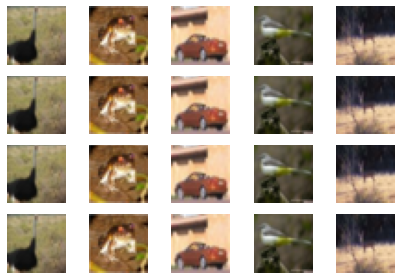

In [40]:
# Show center of cluster (first column) and cluster
def show_neighbors(images, labels, n_neighbors=5):
    nn = utils.CLusteringNN(model, n_neighbors=5)
    nn.fit(images)
    nn_indexes = nn.get_neighbors_indexes(images)
    consistancies = list()
    true_classes = np.argmax(labels, axis=1)
    n = 4
    f, axes = plt.subplots(n, n_neighbors)
    for i, cluster_indexes in enumerate(nn_indexes[:n]):
        for j, im_i in enumerate(cluster_indexes):
            axes[i,j].axis('off')
            axes[i,j].imshow(images[im_i].astype("uint8"))
    plt.tight_layout()
    plt.show()

show_neighbors(X_train, y_train, n_neighbors=5)


## Semantic Clustering

In [17]:
def semantic_clustering_training(base_model, X_train, y_train):
    base_model.load_weights("pretext_task_rotnet.h5")
    num_classes = y_train.shape[1]
    model = add_classification_layer(base_model, num_classes)
    
    n_neighbors = 6
    lr = 1e-4
    e = 0
    m = X_train.shape[0]
    batch_size = 128
    lam = 0.5
    
    # Get clusters
    nn = utils.CLusteringNN(model, n_neighbors=n_neighbors)
    nn.fit(X_train)
    nn_indexes = nn.get_neighbors_indexes(X_train)

    while True:
        e+=1
        batch_count = 0
        for batch_count in range(m//batch_size): # batch
            images_indexes = []
            cluster_images_indexes = []
            batch_ids = np.random.choice(range(0, m), batch_size)
            for i in batch_ids:
                images_indexes += [nn_indexes[i][0]]*(n_neighbors-1)
                cluster_images_indexes += list(nn_indexes[i][1:])

            images = tf.convert_to_tensor(X_train[images_indexes, ...])
            cluster_images = tf.convert_to_tensor(X_train[cluster_images_indexes, ...])

            with tf.GradientTape() as tape:
                images_pred, cluster_images_pred = model(images), model(cluster_images)
                norm = tf.norm(images_pred-cluster_images_pred, ord='euclidean', axis=(1), keepdims=None, name=None)
                consistant_loss = -tf.reduce_sum(tf.math.log(1e-8 + norm))
                
                _ = tf.reduce_sum(images_pred, 0) / len(images)
                entropy_loss = tf.reduce_sum(_ * tf.math.log(1e-8 + _))
                loss = consistant_loss + lam * entropy_loss

                grads = tape.gradient(loss, model.trainable_weights)
                optimizer = tf.keras.optimizers.Adam(lr=lr)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
        if e%1 == 0:
            #clear_output()
            print(f"epoch {e}, loss: {consistant_loss:.2f} + {lam}*{entropy_loss:.2f}={loss:.3f}")
        if e==2:
            break
    return model

semantic_clustering_model = semantic_clustering_training(model, X_train, y_train)

loss: nan + 0.5*nan=nan
loss: nan + 0.5*nan=nan
loss: nan + 0.5*nan=nan
loss: nan + 0.5*nan=nan
loss: nan + 0.5*nan=nan
loss: nan + 0.5*nan=nan
epoch 1, loss: nan + 0.5*nan=nan
loss: nan + 0.5*nan=nan
loss: nan + 0.5*nan=nan
loss: nan + 0.5*nan=nan
loss: nan + 0.5*nan=nan
loss: nan + 0.5*nan=nan
loss: nan + 0.5*nan=nan
loss: nan + 0.5*nan=nan
epoch 2, loss: nan + 0.5*nan=nan


In [ ]:
cluster_probability_associations = semantic_clustering_model.predict(X_train)